In [63]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


In [64]:
data = loadmat('example4kinect_corrected.mat')
amplitude_image = data['amplitudes4']
distance_image = data['distances4']
point_cloud = data['cloud4']

In [65]:
amplitude_image.shape

(424, 512)

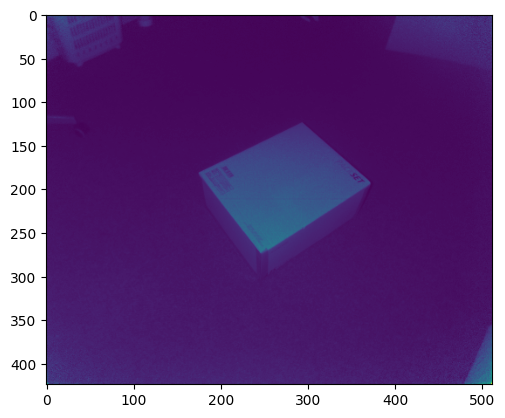

In [66]:
plt.imshow(amplitude_image)
plt.show()

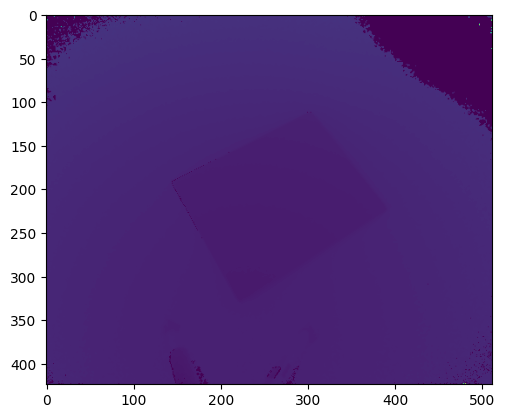

In [67]:
plt.imshow(distance_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


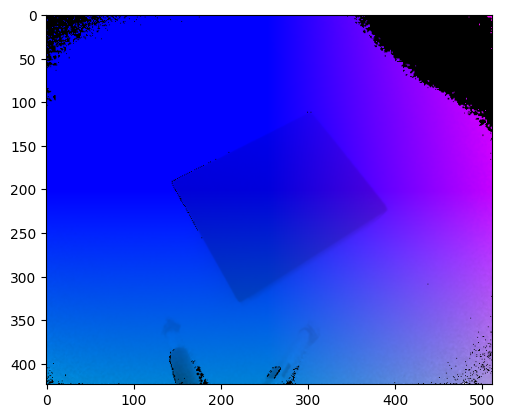

In [68]:
plt.imshow(point_cloud)
plt.show()

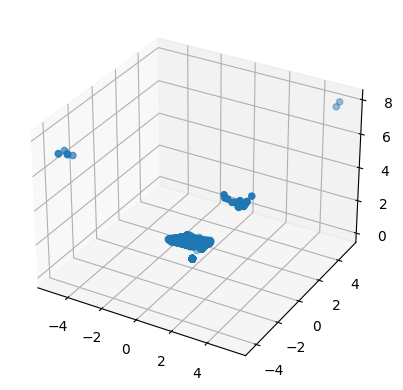

In [69]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:,:,0], point_cloud[:,:,1], point_cloud[:,:,2])
plt.show()

In [70]:
import numpy as np

def RANSAC_plane_fit(point_cloud, threshold, max_iterations):
    best_inliers = []
    best_plane = None

    valid_points = point_cloud[point_cloud[:, 2] != 0]  # Filter out invalid measurements

    for _ in range(max_iterations):
        # Randomly sample three points
        sample_points = valid_points[np.random.choice(valid_points.shape[0], 3, replace=False)]

        # Calculate plane parameters using cross product
        normal = np.cross(sample_points[1] - sample_points[0], sample_points[2] - sample_points[0])
        d = -np.dot(normal, sample_points[0])

        # Compute the distance of all points to the plane
        distances = np.abs(np.matmul(valid_points, normal) + d) / np.linalg.norm(normal)

        # Find inliers
        inliers = valid_points[np.where(distances < threshold)]

        # Check if this model is better
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_plane = (normal, d)

    return best_plane, best_inliers

def visualize_inliers_optimized(point_cloud, inliers):
    reshaped_pc = point_cloud.reshape(-1, 3)
    mask = np.isin(reshaped_pc, inliers).all(axis=1).reshape(point_cloud.shape[0], point_cloud.shape[1])
    
    plt.imshow(mask)
    plt.title('Floor Mask')
    plt.show()
    return mask


In [71]:
# RANSAC parameters
threshold = 0.03  # Just an example value, you might need to adjust this based on your data and unit of measurement
max_iterations = 1000  # This is also a typical value, but you might need to adjust

best_plane, inliers = RANSAC_plane_fit(point_cloud.reshape(-1,3), threshold, max_iterations)



In [72]:
inliers.shape

(166479, 3)

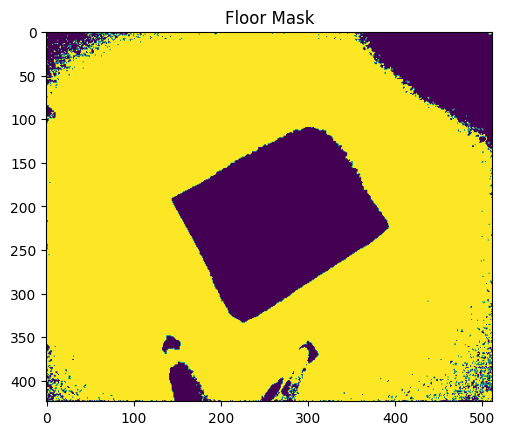

In [73]:
# Now visualize the inliers (floor mask)
mask=visualize_inliers_optimized(point_cloud, inliers)


In [74]:
import numpy as np
nonfloor_cloud = np.stack(((1-mask)*point_cloud[:,:,0], (1-mask)*point_cloud[:,:,1], (1-mask)*point_cloud[:,:,2]), axis=-1)

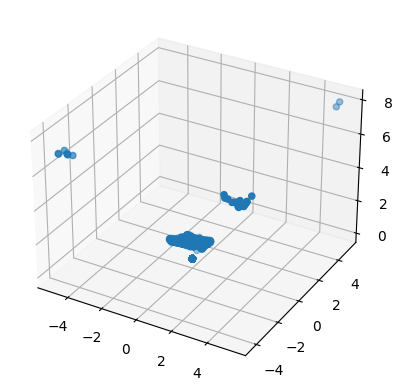

In [75]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(nonfloor_cloud[:,:,0], nonfloor_cloud[:,:,1], nonfloor_cloud[:,:,2])
plt.show()

In [76]:
# RANSAC parameters
threshold = 0.01  # Just an example value, you might need to adjust this based on your data and unit of measurement
max_iterations = 1000  # This is also a typical value, but you might need to adjust
best_plane_second, inliers_second = RANSAC_plane_fit(nonfloor_cloud.reshape(-1,3), threshold, max_iterations)


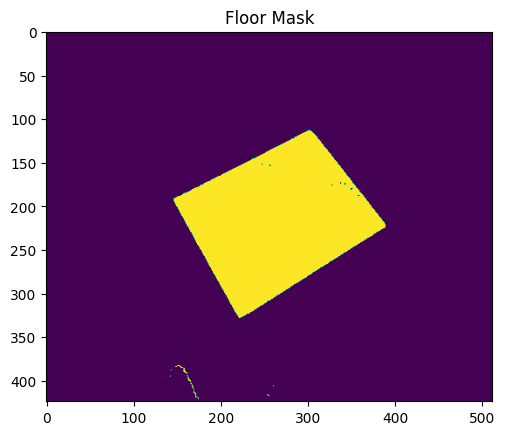

In [77]:
# Now visualize the inliers (floor mask)
mask_second=visualize_inliers_optimized(nonfloor_cloud, inliers_second)


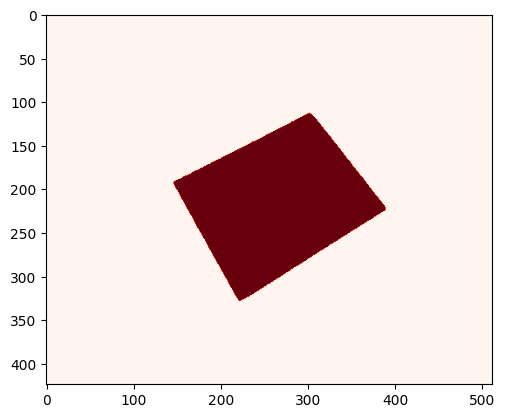

In [78]:
from scipy import ndimage

def extract_largest_component(mask):
    labeled_mask, num_features = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labeled_mask, range(num_features + 1))
    largest_component_label = component_sizes.argmax()
    return (labeled_mask == largest_component_label)

def visualize_mask(mask,cmap):
    plt.imshow(mask, cmap=cmap)
    plt.show()


# Clean up the mask using binary morphological operations
cleaned_mask = ndimage.binary_opening(ndimage.binary_closing(mask_second))

# Extract the largest connected component
largest_component = extract_largest_component(cleaned_mask)

visualize_mask(largest_component,cmap='Reds')


In [79]:
import cv2

def find_corners(mask):
    # Find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour corresponds to the box top
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Approximate a polygon and get vertices
    epsilon = 0.1 * cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    return corners

corners = find_corners(largest_component)


In [80]:
def calculate_dimensions(corners):
    # Convert corners to convenient format
    corners = [corner[0] for corner in corners]
    
    # Calculate pairwise distances
    distances = [np.linalg.norm(np.array(corner1) - np.array(corner2)) for i, corner1 in enumerate(corners) for j, corner2 in enumerate(corners) if i < j]

    # Get the largest two distances
    width= np.average(sorted(list(set(distances)))[0:2])
    length= np.average(sorted(list(set(distances)))[2:4])


    return length, width, distances

length, width,distances= calculate_dimensions(corners)


In [81]:
print(length,width)

185.3535627637134 148.17063998161282


In [82]:
import numpy as np

def compute_distance_between_planes(best_plane,best_plane_second):
    """
    Compute the distance between two parallel planes.
    :param a1, b1, c1, d1: coefficients of the first plane's equation
    :param a2, b2, c2, d2: coefficients of the second plane's equation
    :return: distance between the two planes
    """
    best_plane[0]
    # Ensure the planes are parallel by checking if their normal vectors are the same or in opposite directions
    normal_1 = best_plane[0]
    normal_2 = best_plane_second[0]
    d1=best_plane[1]
    d2=best_plane_second[1]

    # Compute the distance between the two planes
    distance = abs(d1 - d2) / np.linalg.norm(normal_1)

    return distance




In [83]:
best_plane

(array([ 0.00491707, -0.06682825, -0.16793611]), 0.17699263068623444)

In [84]:
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {height_of_box} units.")

The height of the box is: 1.0457056526794095 units.


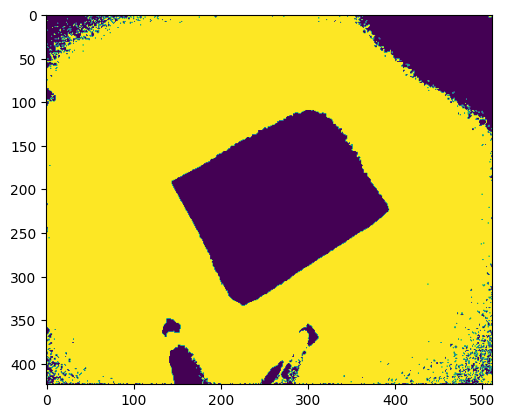

In [85]:
plt.imshow(mask)
plt.show()


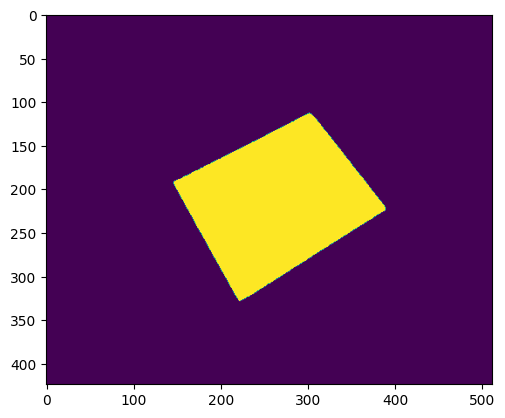

In [86]:
plt.imshow(largest_component)
plt.show()


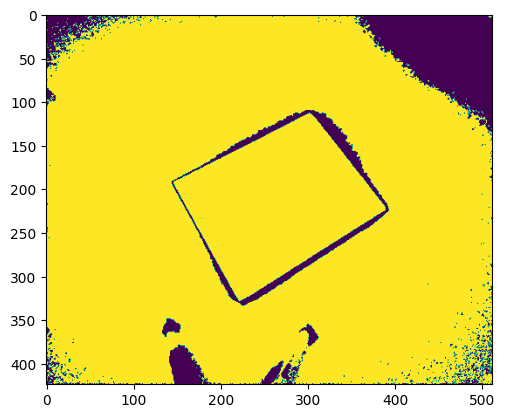

In [87]:
plt.imshow(largest_component+mask)
plt.show()


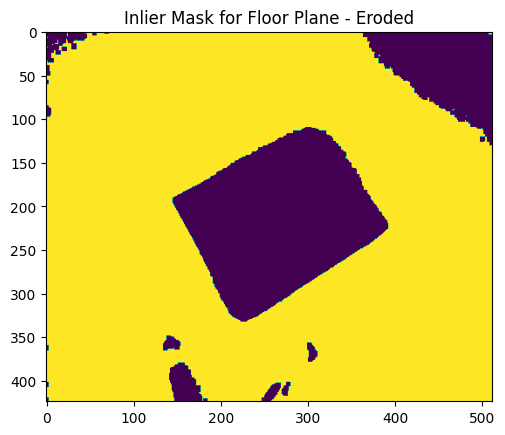

In [88]:
import cv2
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
mask = mask.astype(np.uint8)
 
# Erosion
eroded = cv2.erode(mask, kernel, iterations=1)

# Dilation
dilated = cv2.dilate(mask, kernel, iterations=5)

# Opening
opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Closing
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Visualize
plt.imshow(closed)
plt.title('Inlier Mask for Floor Plane - Eroded')
plt.show()

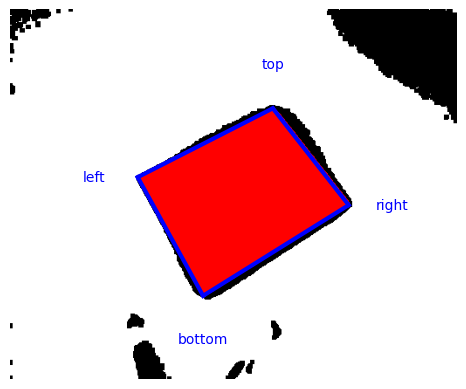

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Create an RGB representation
combined_image = np.zeros((424, 512, 3))

# Set areas where the floor_mask is 1 to some color (e.g., white for this example)
combined_image[closed == 1] = [1, 1, 1]  # Change [1, 1, 1] to desired RGB values

# Set areas where the top_layer_mask is 1 to red
combined_image[largest_component == 1] = [1, 0, 0]

# Example corners for the box's top layer (replace with your corners)
corners1 = corners.squeeze()

# Plot
fig, ax = plt.subplots()
ax.imshow(combined_image)

ax.plot([corners1[0][0], corners1[1][0]], [corners1[0][1], corners1[1][1]], 'b-',linewidth=3)  # Line between 1st and 2nd corner
ax.plot([corners1[1][0], corners1[2][0]], [corners1[1][1], corners1[2][1]], 'b-',linewidth=3)  # Line between 2nd and 3rd corner
ax.plot([corners1[2][0], corners1[3][0]], [corners1[2][1], corners1[3][1]], 'b-',linewidth=3)  # Line between 3rd and 4th corner
ax.plot([corners1[3][0], corners1[0][0]], [corners1[3][1], corners1[0][1]], 'b-',linewidth=3)  # Line between 4th and 1st corner

# Label the corners
offset = 50  # Adjust this value as necessary

ax.text(corners1[0][0], corners1[0][1] - offset, 'top', color='b', fontsize=10, ha='center', va='center')
ax.text(corners1[1][0] - offset, corners1[1][1], 'left', color='b', fontsize=10, ha='center', va='center')
ax.text(corners1[2][0], corners1[2][1] + offset, 'bottom', color='b', fontsize=10, ha='center', va='center')
ax.text(corners1[3][0] + offset, corners1[3][1], 'right', color='b', fontsize=10, ha='center', va='center')

# ... [rest of your code]



plt.axis('off')
plt.show()


<h3>Potential Weaknesses: <br /></h3>

1.Sensitivity to Noise: The simple algorithm may struggle if there is significant noise in the data, leading to incorrect box detections.
Dependence on Assumptions: The algorithm might assume that the second-largest plane always corresponds to the top of the box. In a real-world scenario, this may not always hold true.<br />

2.Inaccuracies in Estimation: The estimation of the corners of the box and subsequently the dimensions might not always be accurate, especially if the box is not perfectly aligned with the axes of the camera or if the box is not a perfect rectangle.<br />

3.Scaling Issues: The algorithm might work well for boxes of certain sizes but may struggle with very small or very large boxes.<br />

4.Lack of Robustness: In cases where multiple objects are present, or if the box has patterns or textures, the algorithm may become less accurate.<br />


<h3>Suggestions for Improvement:<br /></h3>

1.Noise Reduction: Implement filtering techniques to reduce noise from the data before processing. Techniques like median filtering or Gaussian filtering might be beneficial.<br />

2.Robust Plane Detection: Instead of just using RANSAC for plane detection, consider combining it with other techniques or using more advanced variations of RANSAC for improved robustness.<br />

3.Improved Corner Detection: Use more robust corner detection algorithms like Harris or Shi-Tomasi corner detection methods to accurately detect the corners of the box.<br />
